In [1]:
import numpy as np
import matplotlib.pyplot as plt


# Normal Equation

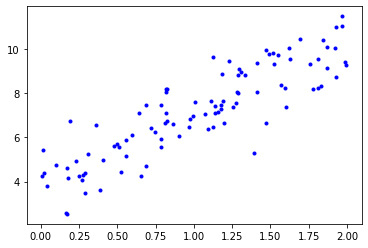

In [2]:
X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100, 1)

plt.plot(X, y, 'b.')
plt.show()

In [3]:
X_b = np.c_[np.ones((100,1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[3.94640242],
       [3.14764721]])

In [4]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2,1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 3.94640242],
       [10.24169684]])

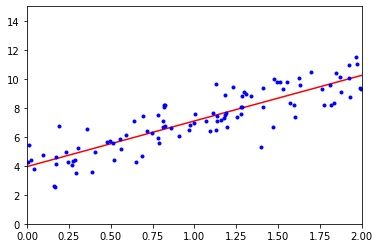

In [5]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0,2,0,15])
plt.show()

# Linear Regression

In [6]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.94640242]), array([[3.14764721]]))

In [7]:
theta_best_svd, residuals, rank, s =np.linalg.lstsq(X_b, y, rcond = 1e-6)
theta_best_svd

array([[3.94640242],
       [3.14764721]])

In [8]:
np.linalg.pinv(X_b).dot(y)

array([[3.94640242],
       [3.14764721]])

# Batch Gradient Descent

In [9]:
eta = 0.1 # Learning Rate 
n_iterations = 1000 
m = 100

theta = np.random.randn(2, 1)

for iteration in range(n_iterations): 
    gradients= 2/m * X_b.T.dot(X_b.dot(theta) - y) 
    theta = theta - eta * gradients

theta

array([[3.94640242],
       [3.14764721]])

# Stochastic Gradient Descent

In [10]:
n_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t0 + t1)

theta = np.random.randn(2, 1)
for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index: random_index+1]
        yi = y[random_index: random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        
theta

array([[3.53091335],
       [3.48887691]])

In [11]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter = 1000, tol = 1e-3, penalty = None, eta0 = 0.1)
sgd_reg.fit(X, y.ravel())

sgd_reg.intercept_, sgd_reg.coef_

(array([3.86749569]), array([3.14092703]))

# Polynomial Regression

In [12]:
m = 300
X = 6 * np.random.rand(m, 1) -3
y = 0.5 * X**2 + X + 2+ np.random.randn(m, 1)

from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree = 2, include_bias = False)
X_poly = poly_features.fit_transform(X)
print(X[0])
print(X_poly[0])


[-0.8440951]
[-0.8440951   0.71249654]


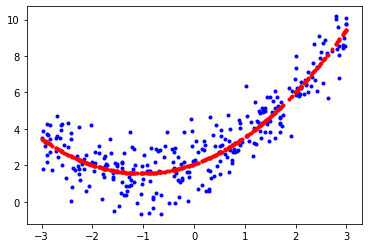

In [13]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

plt.plot(X, y, "b.")
plt.plot(X, lin_reg.coef_[0, 1]* X **2 + lin_reg.coef_[0, 0]* X + lin_reg.intercept_, 'r.')
plt.show()

# Learning Curves

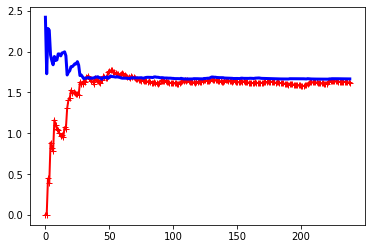

In [14]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, x, y):
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2)
    train_errors , val_errors = [], []
    for m in range(1, len(x_train)):
        model.fit(x_train[:m], y_train[:m])
        y_train_predict = model.predict(x_train[:m])
        y_val_predict = model.predict(x_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth = 2, label = "train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth = 3, label = "val")
    return plt

lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y).show()

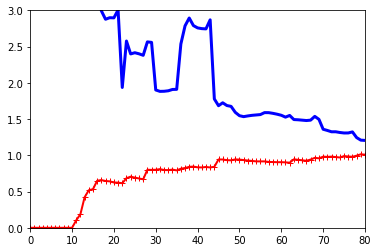

In [15]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree = 10, include_bias = False)),
    ("lin_reg", LinearRegression()),
])

plt = plot_learning_curves(polynomial_regression, X, y)
plt.xlim(0, 80)
plt.ylim(0, 3)
plt.show()

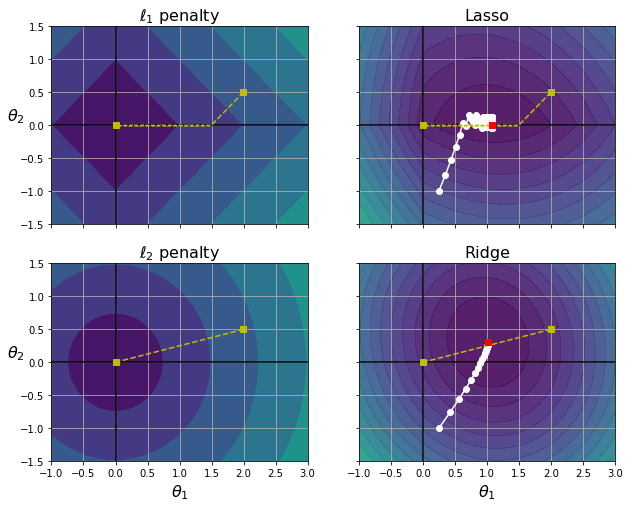

In [16]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.05, n_iterations = 200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + l2 * theta
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))
for i, N, l1, l2, title in ((0, N1, 2., 0, "Lasso"), (1, N2, 0,  2., "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(np.array([[2.0], [0.5]]), Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    ax = axes[i, 0]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, N / 2., levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)
    ax.set_ylabel(r"$\theta_2$", fontsize=16, rotation=0)

    ax = axes[i, 1]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title, fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)

plt.show()

# Ridge Regressions

In [17]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha = 1, solver = "cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[4.95658307]])

In [18]:
sgd_reg = SGDRegressor(penalty = "l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([4.94776207])

# Lasso 

In [19]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([4.90589816])

In [20]:
sgd_reg = SGDRegressor(penalty = "l1")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([4.98916469])

# Elastic Net

In [21]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha = 0.1, l1_ratio = 0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([4.90766721])

# Early Stopping

In [22]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)

# Preparing the data
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree = 90, include_bias = False)),
    ("std_scaler", StandardScaler())
])

x_train_poly_scaled = poly_scaler.fit_transform(x_train)
x_val_poly_scaled = poly_scaler.fit_transform(x_val)

sgd_reg = SGDRegressor(max_iter = 1, tol = -np.infty, warm_start = True,
                        penalty = None, learning_rate = "constant", eta0 = 0.0005)

minimum_val_error = float("inf")
best_epoch, best_model = None, None
for epoch in range(1000):
    sgd_reg.fit(x_train_poly_scaled, y_train.ravel())
    y_val_predict = sgd_reg.predict(x_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

# Sigmoidal Function

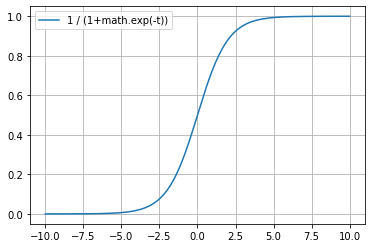

In [23]:
import math

sig_x = list(map(lambda n: n / 10, range(-100, 101)))
sig_y = [1/(1+math.exp(-t)) for t in sig_x]
plt.plot(sig_x, sig_y, label = "1 / (1+math.exp(-t))")
plt.grid()
plt.legend()
plt.show()

# Logit

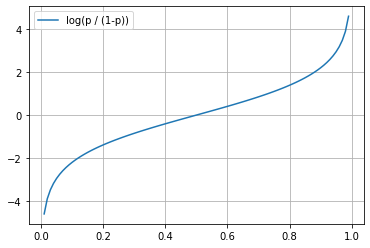

In [24]:
log_x = list(map(lambda n: n / 100, range(1, 100)))
log_y = [math.log(p / (1-p)) for p in log_x]
plt.plot(log_x, log_y, label = "log(p / (1-p))" )
plt.grid()
plt.legend()


# IRIS DATASET

In [25]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [26]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [27]:
X = iris['data'][:, 3:]
y = (iris['target'] == 2).astype(np.int64)

C:\Users\JC122618\AppData\Roaming\Python\Python39\site-packages\matplotlib\patches.py:1387: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  verts = np.dot(coords, M) + (x + dx, y + dy)


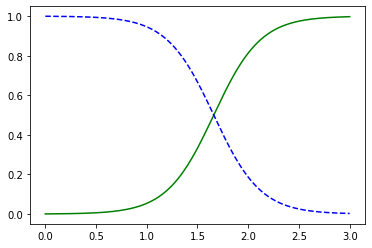

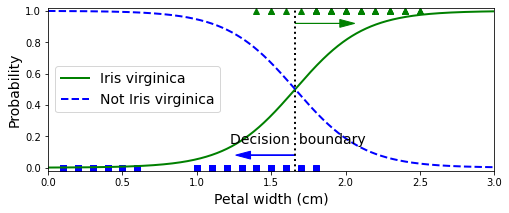

In [28]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]
plt.plot(X_new, y_proba[:, 1], "g-", label = "Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label = "Not Iris virginica")

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])

plt.show()

In [29]:
log_reg.predict([[1.7],[1.5]])

array([1, 0], dtype=int64)

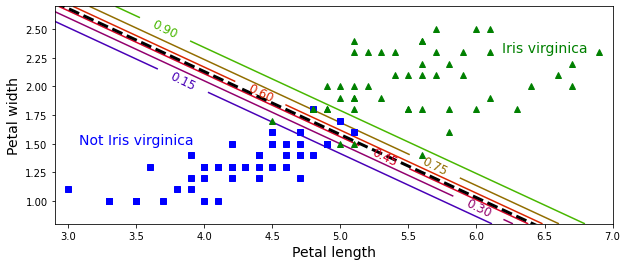

In [30]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int64)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])

plt.show()

In [31]:
X = iris['data'][:, (2,3)]
y = iris['target']

softmax_reg = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', C = 10)
softmax_reg.fit(X, y)
print(softmax_reg.predict([[5, 2]]))
print(softmax_reg.predict_proba([[5, 2]]))

[2]
[[6.38014896e-07 5.74929995e-02 9.42506362e-01]]


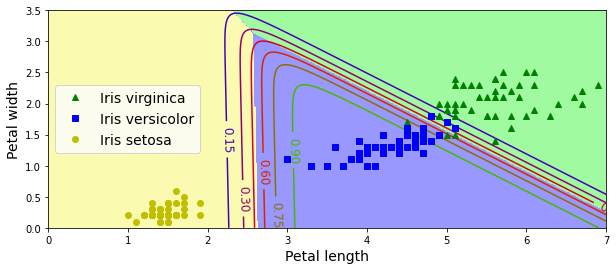

In [32]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])

plt.show()